**Import the necessary libraries**

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


**EDA**

In [3]:
# Load the dataset
file_path = '/kaggle/input/bank-marketing/bank-additional-full.csv'
df = pd.read_csv(file_path, sep=';')

In [4]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [6]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


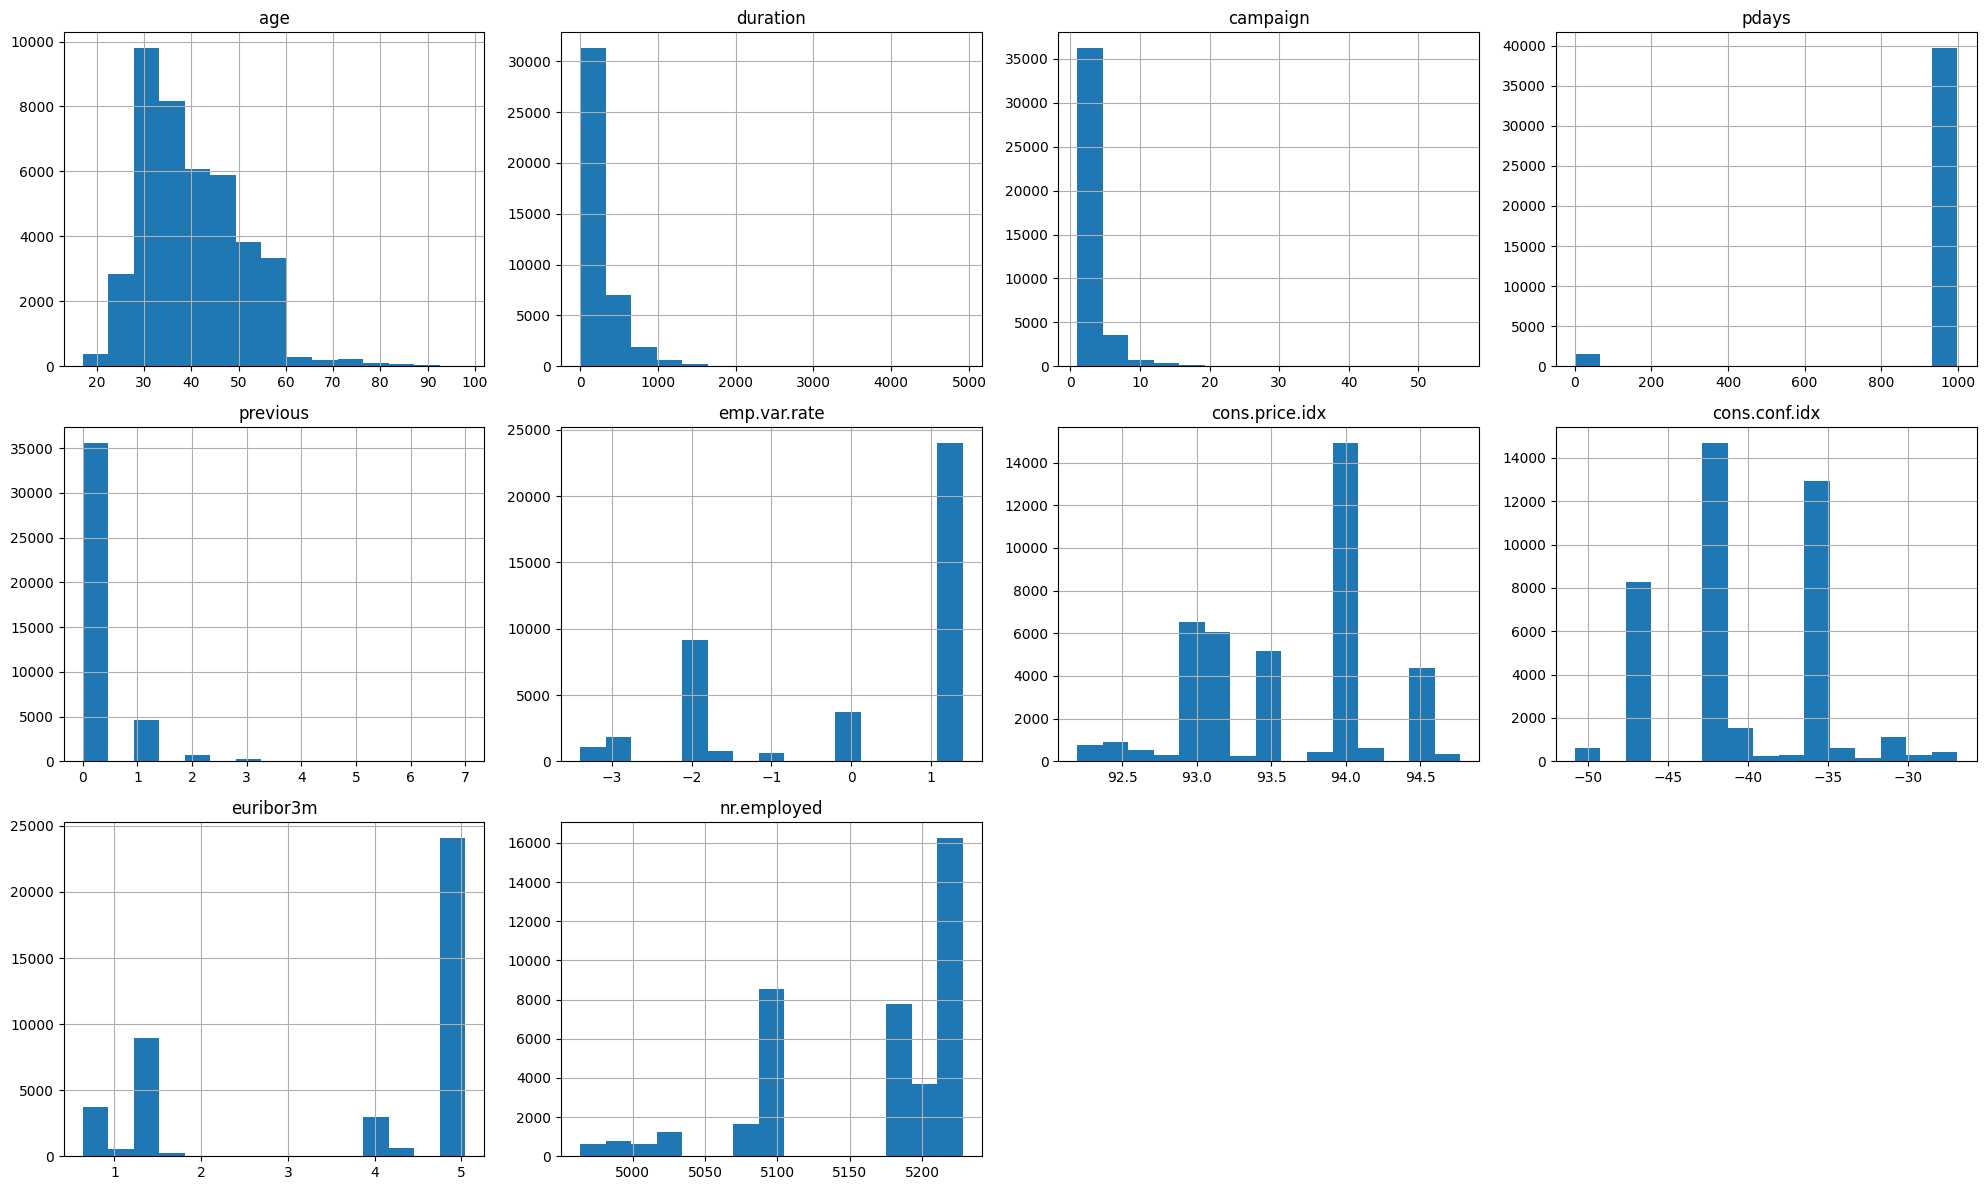

In [7]:
#Plotting the numerical features using a histogram

numerical_features = df.select_dtypes(include=['int64', 'float64']).columns
num_rows = int(len(numerical_features) / 4) + (len(numerical_features) % 4 > 0)
df[numerical_features].hist(bins=15, figsize=(20, num_rows * 4), layout=(num_rows, 4))
plt.tight_layout()
plt.show()

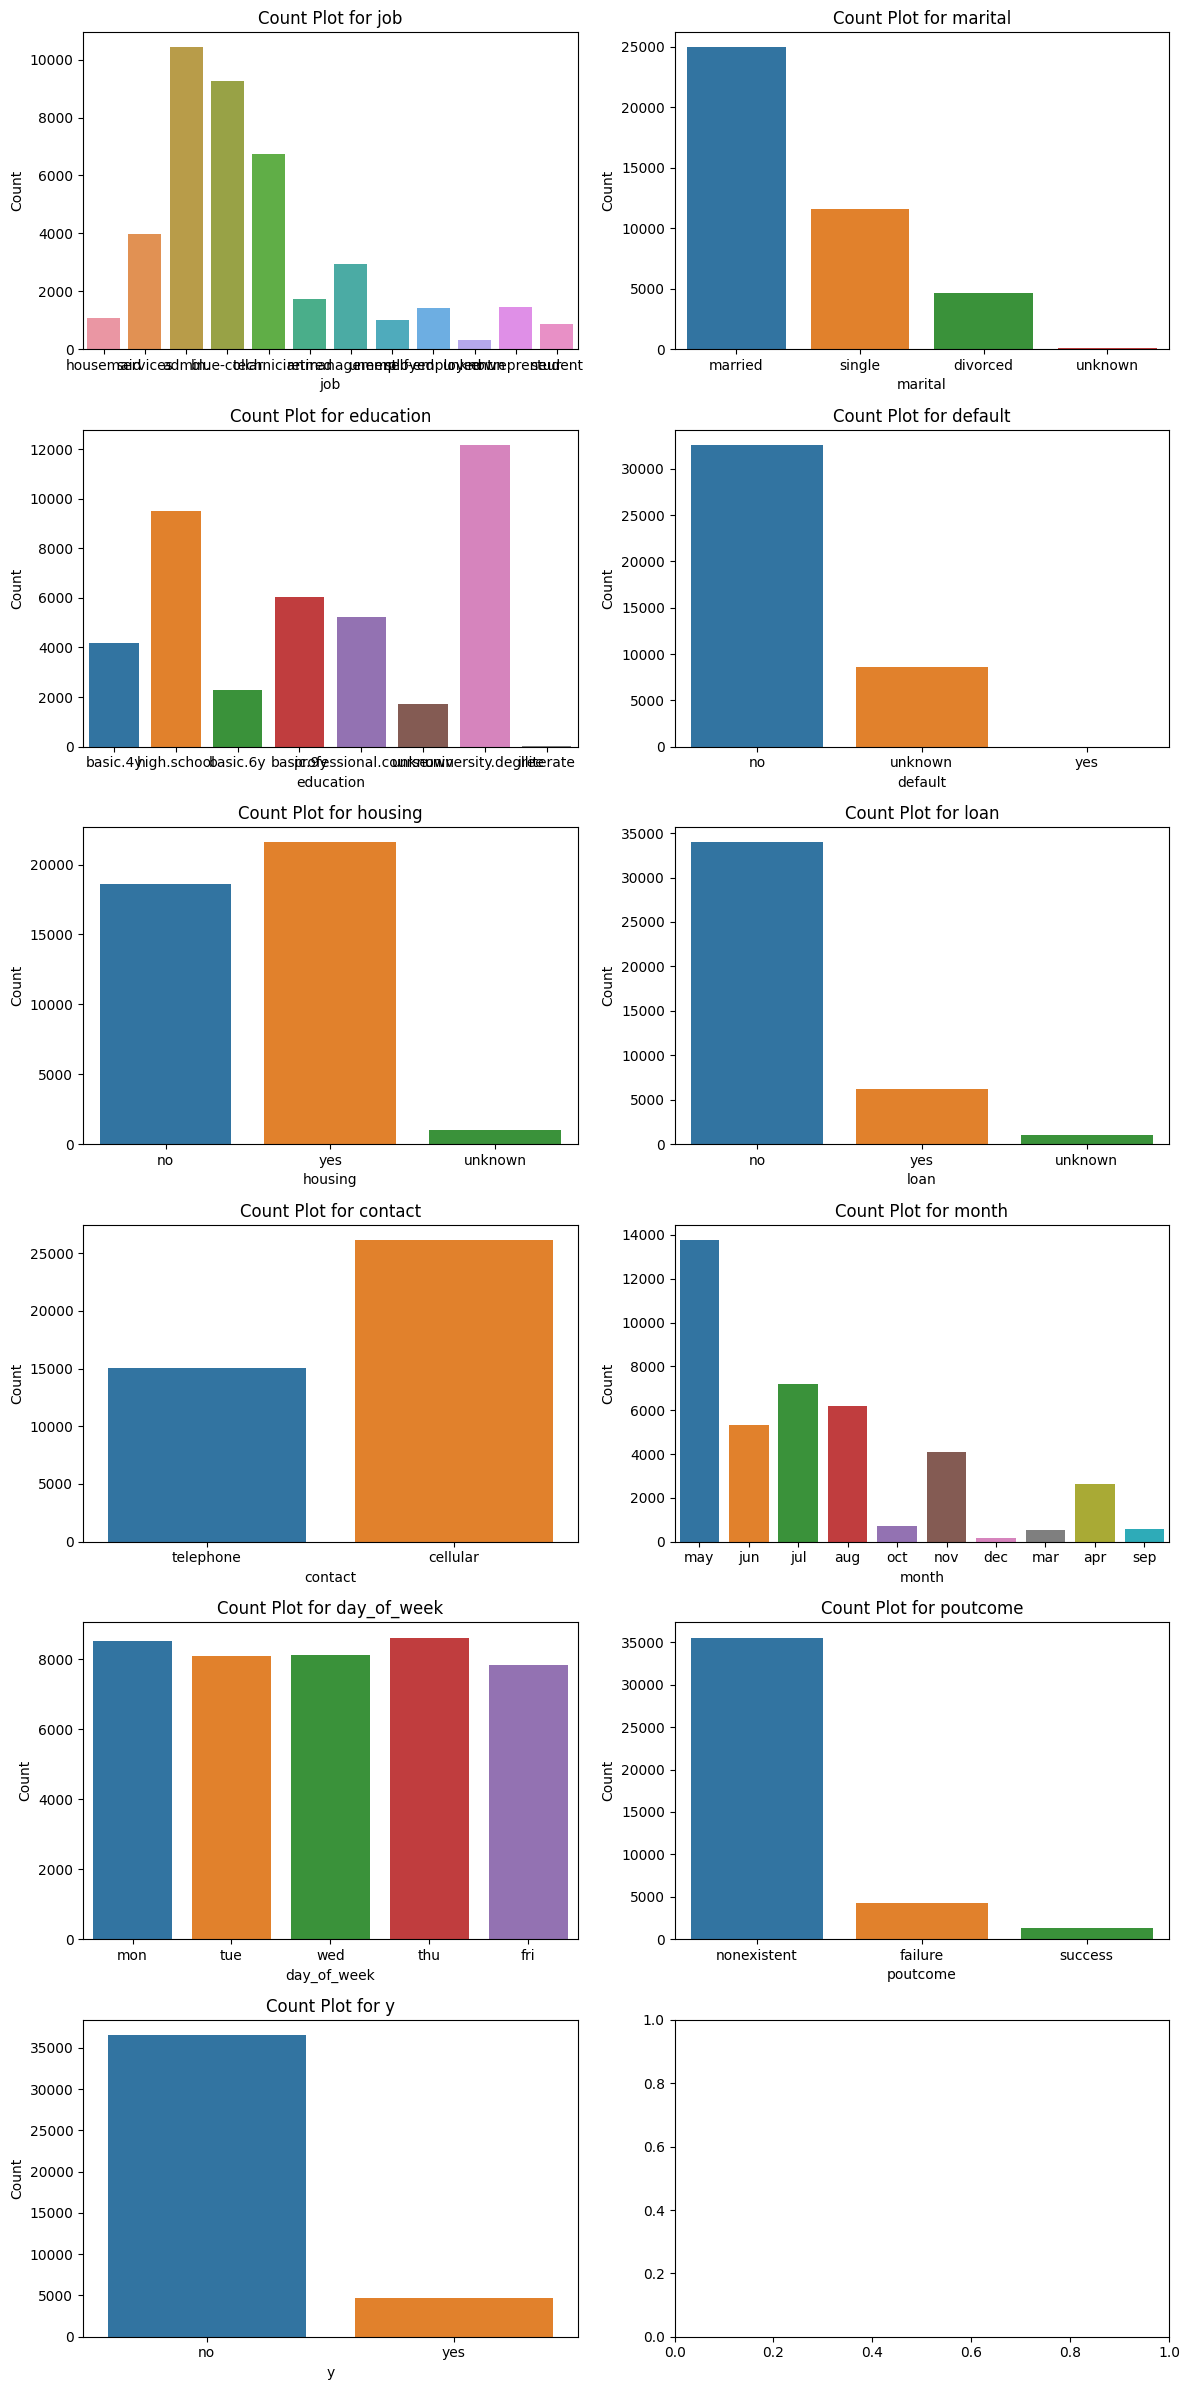

In [8]:
#Plotting the categorical features using a histogram

cat_features = df.select_dtypes(include=['object']).columns

# Set up subplots
num_rows = int(len(cat_features) / 2) + (len(cat_features) % 2 > 0)
fig, axes = plt.subplots(num_rows, 2, figsize=(12, 4 * num_rows))

# Flatten the axes array if there's only one row
axes = axes.flatten()

# Plot count plots for each categorical feature
for i, cat_feature in enumerate(cat_features):
    sns.countplot(x=cat_feature, data=df, ax=axes[i])
    axes[i].set_title(f'Count Plot for {cat_feature}')
    axes[i].set_xlabel(cat_feature)
    axes[i].set_ylabel('Count')

# Adjust layout
plt.tight_layout()
plt.show()

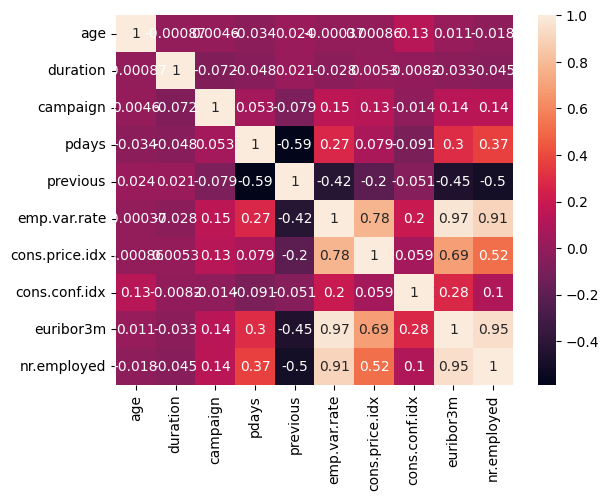

In [10]:
# correlation heatmap for all features
import numpy as np
corr = df[numerical_features].corr()
mask = np.zeros_like(corr, dtype=bool)
sns.heatmap(corr, annot=True)
plt.show()

**Data Preparation**

In [11]:
# Identify categorical and numerical columns
categorical_cols = df.select_dtypes(include=['object']).drop('y', axis=1).columns.tolist()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Define the target and features
y = df['y'].map({'yes': 1, 'no': 0}).values
X = df.drop('y', axis=1)

# Splitting the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Define two pre-processing pipelines (numerical_transformer and categorical_transformer)
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
])

# Create a pipeline that first preprocesses the data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Apply SMOTE to training data
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_preprocessed, y_train)

**Model Building**

In [14]:
# Building the neural network model
model = Sequential([
    Dense(128, activation='relu', input_dim=X_train_resampled.shape[1]),
    BatchNormalization(),
    Dropout(0.5),  # Increased dropout rate for more regularization
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),  
    Dense(16, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),  
    Dense(8, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compiling the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)  # Adjusted learning rate
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15)  # Increased patience
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

# Training the model
history = model.fit(
    X_train_resampled, y_train_resampled, 
    epochs=60,  # Increased number of epochs
    batch_size=32,  # Adjusted batch size
    validation_split=0.2, 
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/60
1462/1462 [==============================] - 15s 8ms/step - loss: 0.6538 - accuracy: 0.6252 - val_loss: 0.5172 - val_accuracy: 0.9293
Epoch 2/60
1462/1462 [==============================] - 11s 7ms/step - loss: 0.4399 - accuracy: 0.7972 - val_loss: 0.3594 - val_accuracy: 0.9563
Epoch 3/60
1462/1462 [==============================] - 11s 7ms/step - loss: 0.3863 - accuracy: 0.8335 - val_loss: 0.3418 - val_accuracy: 0.9582
Epoch 4/60
1462/1462 [==============================] - 11s 7ms/step - loss: 0.3664 - accuracy: 0.8455 - val_loss: 0.3184 - val_accuracy: 0.9665
Epoch 5/60
1462/1462 [==============================] - 11s 7ms/step - loss: 0.3552 - accuracy: 0.8501 - val_loss: 0.3068 - val_accuracy: 0.9537
Epoch 6/60
1462/1462 [==============================] - 10s 7ms/step - loss: 0.3477 - accuracy: 0.8567 - val_loss: 0.3151 - val_accuracy: 0.9524
Epoch 7/60
1462/1462 [==============================] - 11s 7ms/step - loss: 0.3443 - accuracy: 0.8574 - val_loss: 0.2965 - val_ac

**Training**

In [15]:
# Load the best model
model = tf.keras.models.load_model('best_model.h5')

# Evaluate the model on the processed test set
loss, accuracy = model.evaluate(X_test_preprocessed, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

258/258 [==============================] - 1s 3ms/step - loss: 0.2420 - accuracy: 0.8836
Test Accuracy: 0.88
